In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, ranksums, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import multipletests

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')

#os.chdir('/home/ak431480')

### Load pySCENIC results

In [2]:
grns = pd.read_csv('/scratch/svc_td_compbio/users/kiviaho/hillock_club_senescence/scGRN/regulons_pruned_grn_20260121.csv')
import ast

grns[['Target', 'Score']] = (
    grns['TargetGene']
    .apply(ast.literal_eval)
    .apply(pd.Series)
)
grns = grns.drop(columns=['TargetGene'])
grns = grns.sort_values('Score',ascending=False).reset_index(drop=True)

# FILTER: Score at least 1.00
grns = grns[grns['Score'] > 1.00]

# FILTER: At least 10 target genes for the TF
grns = grns[grns['TF'].isin(
    grns['TF'].value_counts()[(grns['TF'].value_counts() >= 10)].index.tolist()
)]

# sort by TF and decreasing Score
grns_sorted = grns.sort_values(['TF', 'Score'], ascending=[True, False])

# group targets per TF into lists
grns_df = (
    grns_sorted
    .groupby('TF')['Target']
    .apply(list)
    .to_frame()
)

# expand lists into columns (ragged columns allowed → NaN)
grns_df = pd.DataFrame(grns_df['Target'].tolist(), index=grns_df.index).T

grns_dict = grns_df.to_dict('list')
grns_dict = {
    k: [x for x in v if pd.notna(x)]
    for k, v in grns_df.to_dict('list').items()
}


grns_df.head(20)

TF,AR,ASCL1,ATF3,ATF4,BATF,BHLHE40,BHLHE41,CEBPB,CEBPD,CREB3,...,SOX4,SOX9,SPDEF,SPIB,SREBF1,STAT1,STAT3,TBX21,TCF12,TGIF1
0,FASN,INSM1,RHOB,ESRRA,TNFRSF18,HSD17B13,TMPRSS11E,ZFP36L1,CEBPB,AGTRAP,...,CRIP2,MT1F,MPC2,CD180,TMPRSS2,IFI44L,FOXP1,FOXE1,SYT1,S100A11
1,HIST1H2AC,HES6,TOB1,JUND,ICOS,ELF3,IL20RB,SAA1,MARCKS,MYDGF,...,NFIB,MT1M,ATP6V1G1,MGAM2,DHCR24,IRF9,PTPRF,GNLY,CALCA,SRI
2,HIST1H1C,NELL2,MCL1,NRARP,CCR6,PRSS22,KRT13,ARL6IP1,IFITM3,CLGN,...,TUBA1A,NFIB,HMG20B,MT3,STEAP2,ERG,NFIB,LINC01331,FXYD6,S100A13
3,ADI1,KLK12,EGR3,MT1X,TNFRSF1B,CEACAM6,LY6D,S100A11,C9orf3,KIF1A,...,KRT18,MT1X,LYPLA1,S100A9,SCD,CALML5,NFIC,H2AFB1,RIMBP2,SORBS2
4,ACACA,RGS7,BRD2,GADD45G,ETS1,KRT16,ANXA8L1,HES4,CPB1,CYB561,...,MAX,EPHX1,TPD52,CHIT1,SURF4,AK5,RRBP1,IKZF1,NELL2,PLPP2
5,HIST1H4H,CHGB,NFKBIZ,RHOB,ZBTB32,MSLN,LSP1,SPIB,LAPTM4A,A1BG,...,MDK,PTPRK,HIST1H1C,MMP9,CYB561,ST8SIA6-AS1,SLC44A4,XCL2,PPP1R1C,EPHX1
6,CISD3,ST18,KLF4,ERG,IL2RB,PIM3,POU6F2,CEBPD,B2M,TMEM79,...,SORBS2,APP,SMS,SFRP4,PLPP1,LINC01269,CD151,RUNX3,DAPL1,LGALS3
7,SLC25A39,SPRR1A,SLC38A2,RBPJ,LAIR2,PTK6,TMPRSS4,LAPTM4A,CD9,NPDC1,...,S100A13,ACTB,PTMS,FAM166B,CPM,HOPX,NFIA,SNAI3,C2orf40,NCOA7
8,HIST1H2BK,LY6H,H2AFX,SLC16A1,SNAI3,OLFM4,DSC3,HLA-E,HLA-E,PRDM8,...,KRT8,FOXP1,ALDH1A3,CCL21,ERLEC1,GP2,LGALS3BP,FOXF2,GRP,CLCF1
9,FAM162A,ELAVL4,MAFF,PKNOX2,CREM,SERPINB5,CST6,GSTP1,RBBP6,SLC39A10,...,TUBB2B,CREB5,NME4,CCL20,ELK4,EEF1A2,FLNB,XCL1,CGA,DEFB1


In [3]:
# Load scs data
base_dir = '/scratch/svc_td_compbio/users/kiviaho'
adata_concat = sc.read_h5ad(f'{base_dir}/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')

# Celltype_annotation
celltype_annotation_df = pd.read_excel('/home/ak431480/single_cell_celltype_annotation.xlsx',index_col=0)
celltype_annot_dict = celltype_annotation_df.to_dict()['celltype name']

# Map the annotation
adata_concat.obs['annotated celltypes'] = adata_concat.obs['celltype_leiden'].map(celltype_annot_dict)
adata_concat = adata_concat[~(adata_concat.obs['annotated celltypes'] == 'drop')]
adata_concat = adata_concat[adata_concat.obs['cell_type'] == 'Epithelial cell'].copy()
adata_concat
#adata_concat = adata_concat[adata_concat.obs['annotated celltypes'] == 'Epithelial cell']

AnnData object with n_obs × n_vars = 38217 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'celltype_leiden', 'annotated celltypes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'

In [4]:

for sig in grns_dict:
    print(sig)
    sc.tl.score_genes(adata_concat,grns_dict[sig],score_name=sig,random_state=98464585,layer='log1p')

AR
ASCL1
ATF3
ATF4
BATF
BHLHE40
BHLHE41
CEBPB
CEBPD
CREB3
CREB3L4
CREM
EGR1
EHF
ELK4
EMX2
ERG
ETS1
ETS2
ETV5
FOS
FOSL1
FOXA1
FOXC1
FOXO3
FOXP1
GATA2
GATA3
HAND2
HNF1A
HOXA10
HOXB13
HOXB7
HSF1
IKZF1
IRF1
IRF4
IRF6
JUN
JUNB
JUND
KLF4
KLF5
MAF
MAFB
MAFF
MAX
MAZ
MEF2C
MYC
NFE2L2
NFIA
NFIC
NFIX
NFKB2
NKX3-1
NR2F1
NR3C1
OVOL1
REL
RELB
RORA
RUNX3
RXRG
SOX10
SOX15
SOX2
SOX4
SOX9
SPDEF
SPIB
SREBF1
STAT1
STAT3
TBX21
TCF12
TGIF1


In [5]:
obs_data = adata_concat.obs.copy()
obs_data['annotated celltypes'] = pd.Categorical(obs_data['annotated celltypes'], categories = [
    'FOLH1+ cancer',
    'ARhigh mixed identity', 
    'NKX3-1+ cancer',
    'AMACR+ cancer',
    'CHGA+ neuroendocrine',
    'KRT5+ basal',
    'PIGR+ club-like',
    'ARlow mixed identity'])

/tmp/ipykernel_118050/3069220916.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


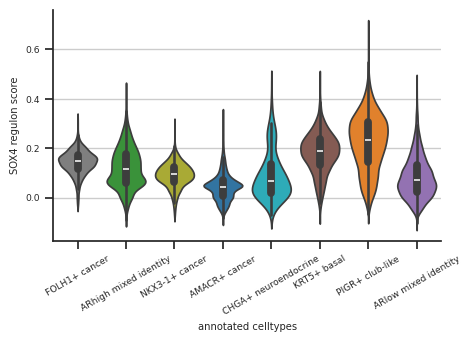

/tmp/ipykernel_118050/3069220916.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


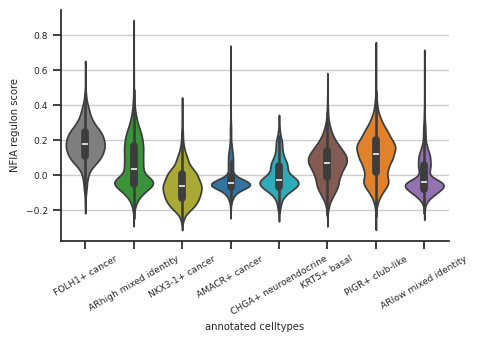

/tmp/ipykernel_118050/3069220916.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


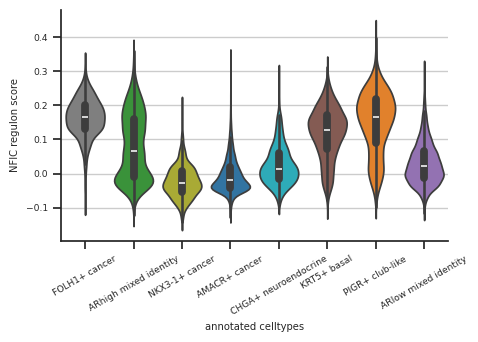

/tmp/ipykernel_118050/3069220916.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


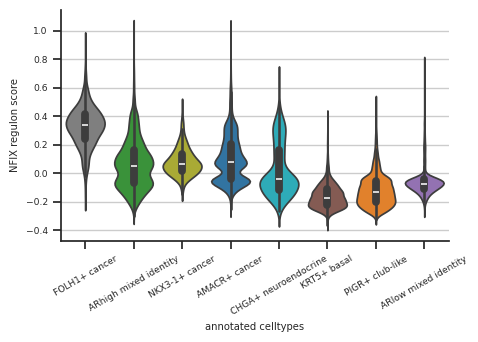

/tmp/ipykernel_118050/3069220916.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


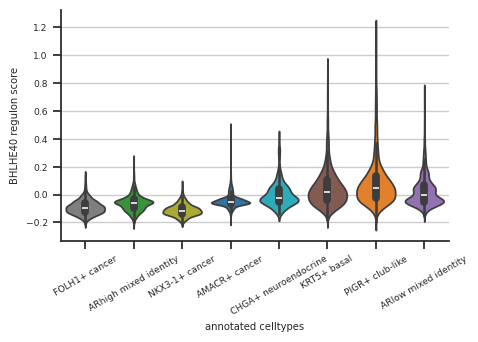

In [6]:
sns.set_theme(
    style='white',
    palette=sns.color_palette([
        sns.color_palette('tab10')[7],
        sns.color_palette('tab10')[2],
        sns.color_palette('tab10')[8],
        sns.color_palette('tab10')[0],
        sns.color_palette('tab10')[9],
        sns.color_palette('tab10')[5],
        sns.color_palette('tab10')[1],
        sns.color_palette('tab10')[4],
    ]),
    font_scale=0.6,
    rc={'xtick.bottom': True, 'ytick.left': True}
)

#highly_variable_tf_regulons = obs_data[grns_dict.keys()].var().sort_values(ascending=False)[:40].index.tolist()
highly_variable_tf_regulons = ['SOX4','NFIA','NFIC','NFIX','BHLHE40']


for tf_regulon_name in highly_variable_tf_regulons:

    fig, ax = plt.subplots(figsize=(5,3))
    sns.violinplot(obs_data,
        x = 'annotated celltypes',
        y = tf_regulon_name,
        hue = 'annotated celltypes'
    )
    ax.grid(axis='y')
    ax.set_ylabel(f'{tf_regulon_name} regulon score')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    ax.spines[['top','right']].set_visible(False)

    plt.show()

In [65]:
grns_df.to_excel('/home/ak431480/grn_regulons_from_lyu_2024_scs_data_20260122.xlsx')